In [52]:
#Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

#For task 5:
from scipy.special import erfc



In [30]:
#Task 1 : Loading image and generate 8-bit PCM bitstream
img = cv2.imread("cameraman.png",cv2.IMREAD_GRAYSCALE)
M, N = img.shape    #returns (rows,columns) = (M,N)
x = img/255         #normalize pixel values to [0,1]
x_vec = x.flatten() #2D matrix to 1D sequence of symbols

#pcm_encoding
#b = 8
#L = 256

def pcm_encode(x,b):
    
    L = 2**b
    delta = 1/L  #step size
    k = np.floor(x/delta)
    k = np.clip(k,0,L-1).astype(int)
    xcap = (k + 0.5)*delta

    Ps = np.mean(x**2)         #signal power
    Pn = np.mean((x-xcap)**2)  #noise power
    SQNR_dB = 10 * np.log10(Ps/Pn) #SNR calculation

    bitstream = ""
    for v in k:
        bitstream += np.binary_repr(int(v),width = 8)
    b_tx = np.array(list(bitstream),dtype = np.uint8)
    return k, xcap, b_tx, bitstream

b = 8
b_tx = pcm_encode(x_vec, b)[2]



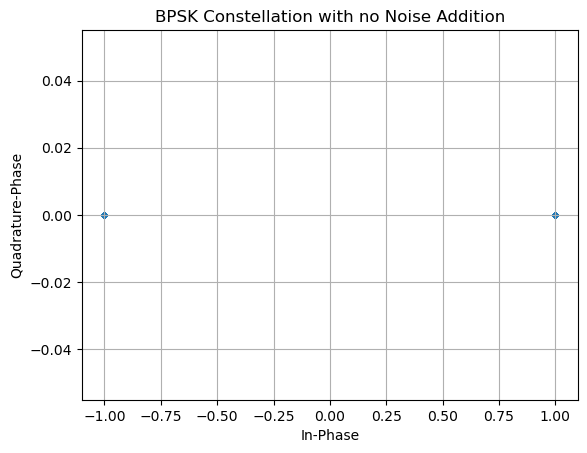

In [29]:
#Task 2 : BPSK Modulation and Constellation

#now from b_tx we map bits to BPSK Symbols
#generate BPSK Modulated signal
#plot constellation graph

Eb = 1
bipolar = 1 - 2*b_tx.astype(int)  # 0 maps to +1, 1 maps to -1
s = bipolar * np.sqrt(Eb)  #symbols of BPSK Modulated signals

plt.figure()
plt.scatter(s,np.zeros_like(s),s=10)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature-Phase")
plt.title("BPSK Constellation with no Noise Addition")
plt.grid()
plt.show()

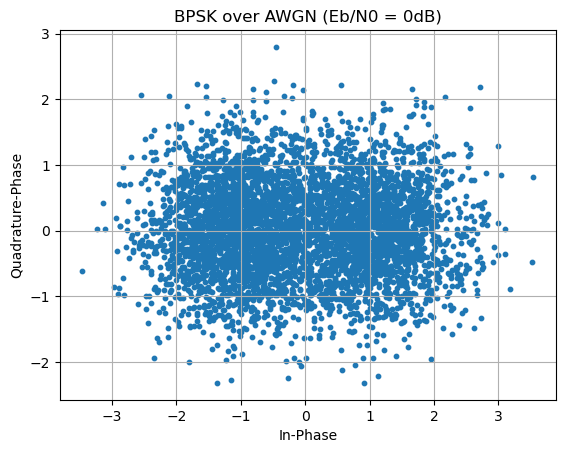

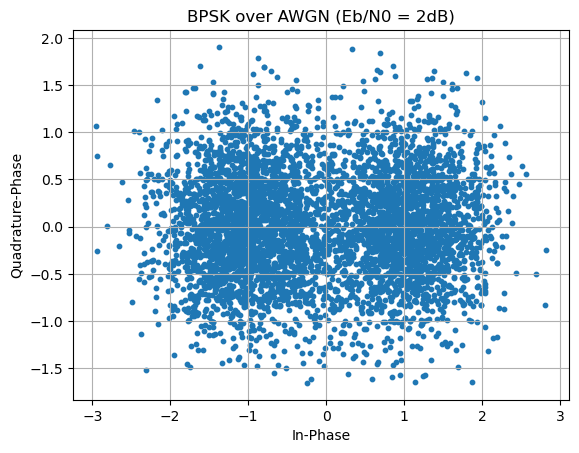

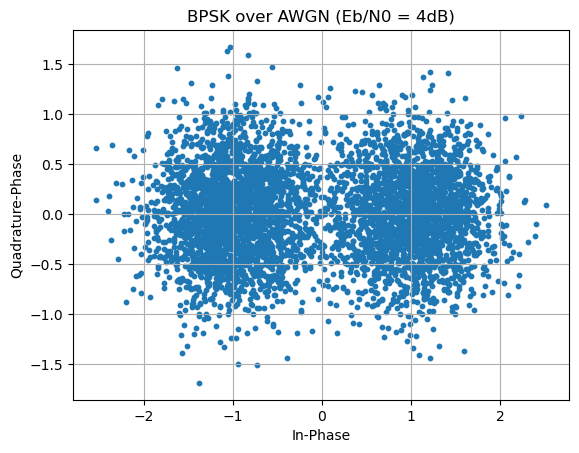

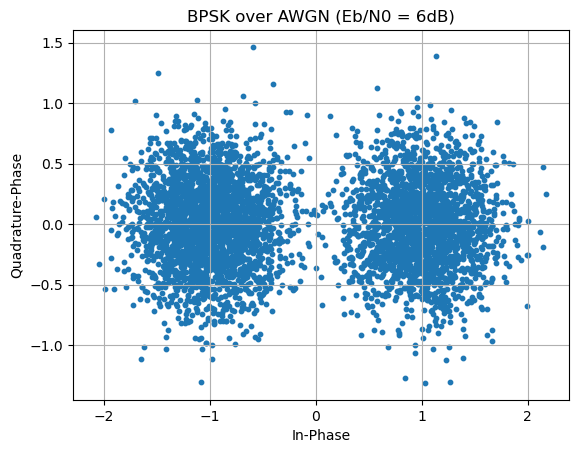

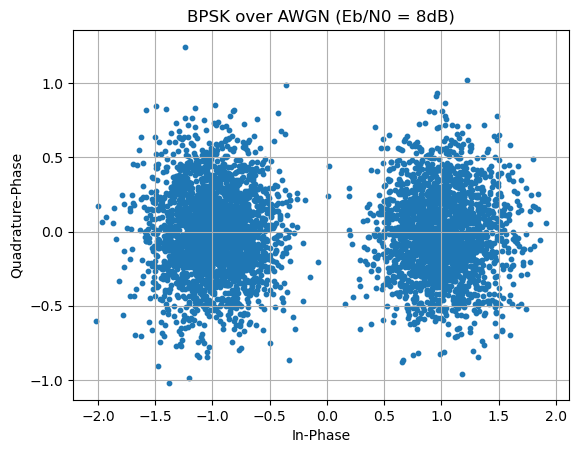

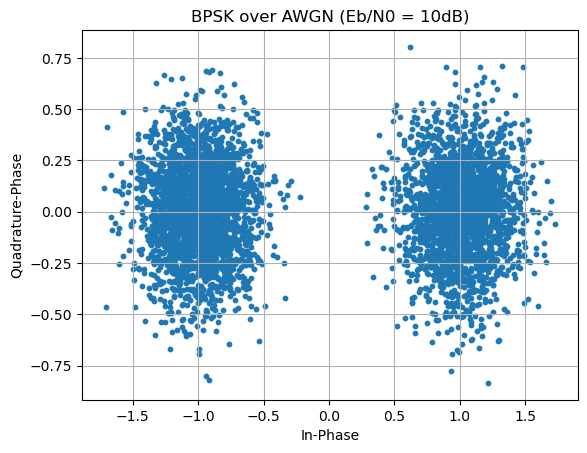

In [31]:
#Task 3 : AWGN Channel simulation (complex basebad) for multiple Eb/N0 values
#Eb/N0 in dB = [0,2,4,6,8,10]
#add complex AWGN
#observe spreading in I-Q plane

list_y = []  #list of received signals

Eb = 1
EbN0_dB = np.arange(0,11,2) # 0,2,4,6,8,10
EbN0_lin = 10 ** (EbN0_dB/10)

for i in range(len(EbN0_lin)):
    N0 = Eb/EbN0_lin[i]
    noise_variance = N0/2

    nI = np.sqrt(noise_variance)*np.random.randn(len(s))   #in phase noise components
    nQ = np.sqrt(noise_variance)*np.random.randn(len(s))   #quadrature noise components
    n = nI + 1j*nQ

    y = s + n      #total signal
    list_y.append(y)


#For each Eb/N0 produce scatter plot of received symbols

for i in range(len(EbN0_dB)):
    plt.figure()
    plt.scatter(np.real(list_y[i][:5000]), np.imag(list_y[i][:5000]),s=10)
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature-Phase")
    plt.title(f"BPSK over AWGN (Eb/N0 = {EbN0_dB[i]}dB)")
    plt.grid()
    plt.show()

Eb/N0 = 0 dB : BER = 0.077818
Eb/N0 = 2 dB : BER = 0.037603
Eb/N0 = 4 dB : BER = 0.012419
Eb/N0 = 6 dB : BER = 0.002356
Eb/N0 = 8 dB : BER = 0.000193
Eb/N0 = 10 dB : BER = 0.000002


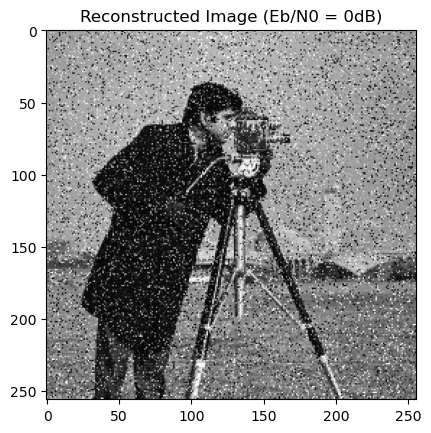

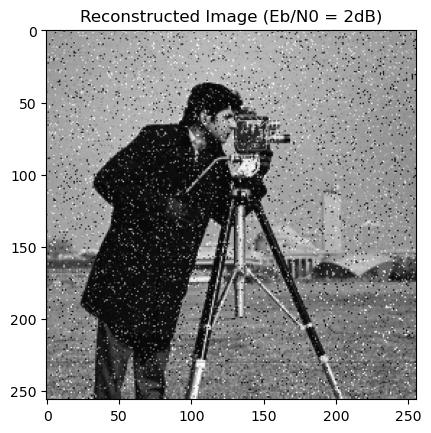

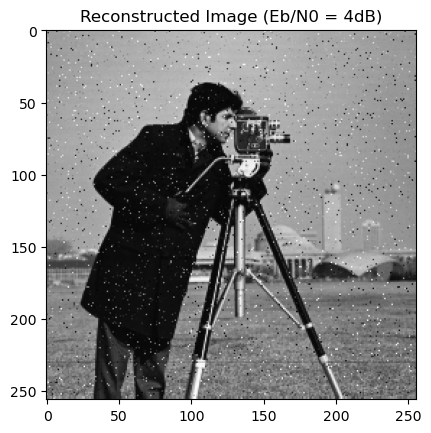

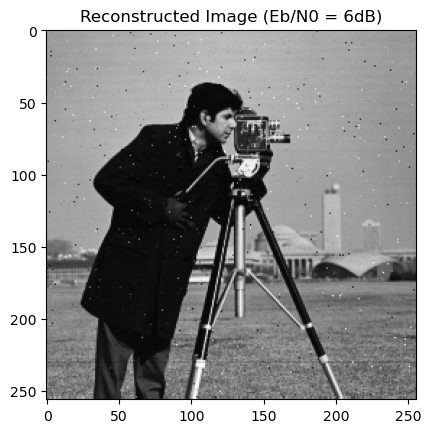

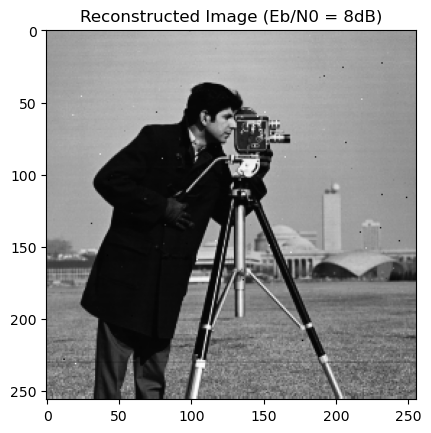

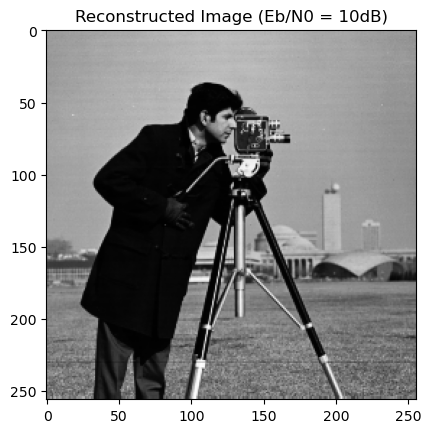

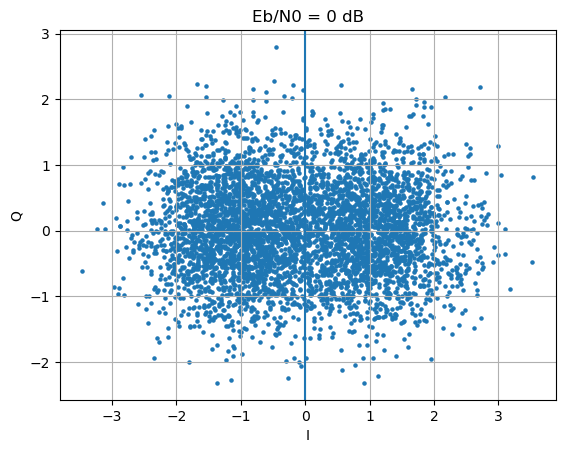

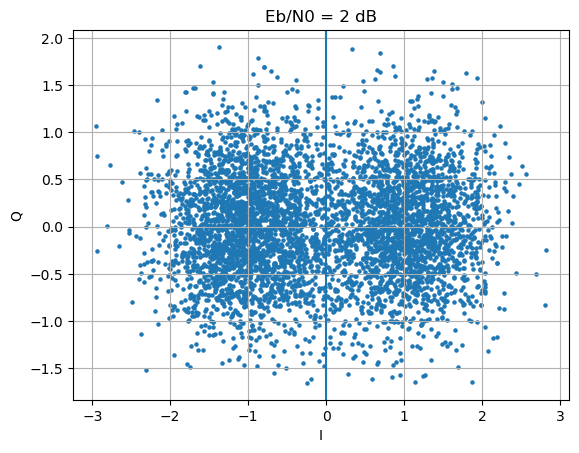

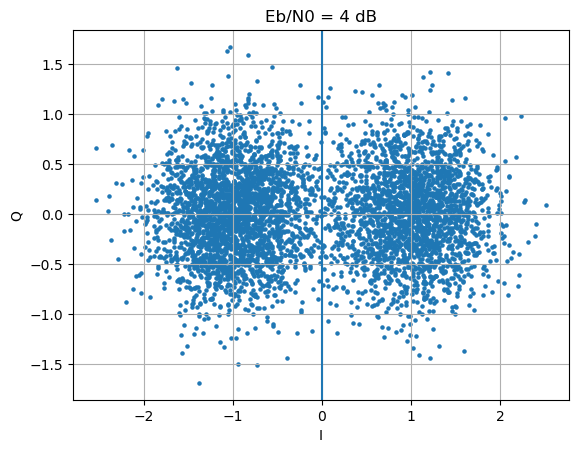

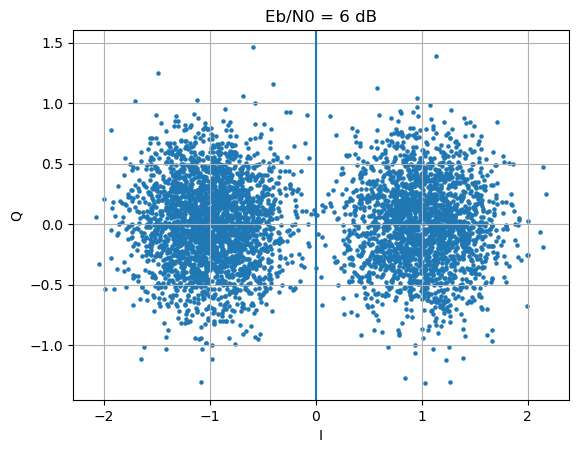

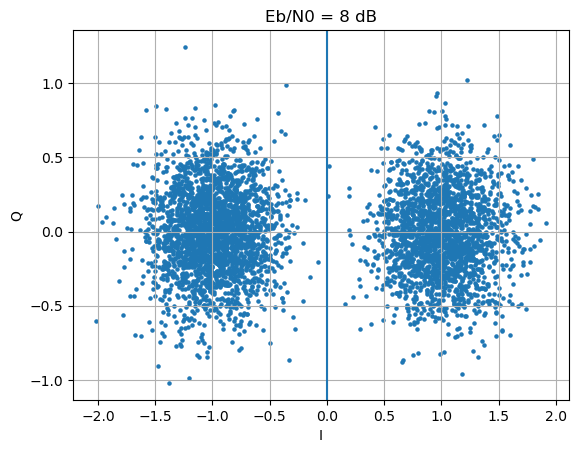

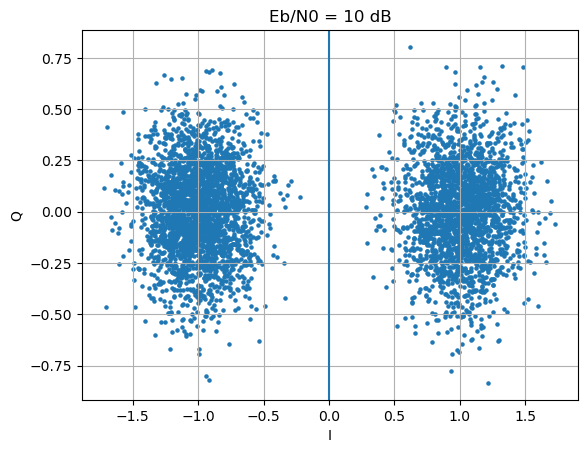

In [50]:
#Task 4 : ML detection, BER Calculation, and reconstructed image (complex baseband)

#ML: maximum likelihood 
#ML detection
list_b_rx = []

for i in range(len(EbN0_dB)):
    y = list_y[i]
    b_rx = (np.real(y)<0).astype(int)
    list_b_rx.append(b_rx)

#simulated BER Calculation
sim_BER = []

for i in range(len(EbN0_dB)):
    bit_error = np.sum(b_tx != list_b_rx[i])
    BER = bit_error/len(b_tx)
    sim_BER.append(BER)

#PCM Decoding and reconstructing

def pcm_decode(b_rx, b, M, N):
    L = 2**b
    delta = 1 / L
    total_bits = (len(b_rx) // b) * b
    b_rx = b_rx[:total_bits] #drops extra bits caused by channel truncation
    bits = b_rx.reshape(-1, b) #each row is one symbol

    #converting binary number into a digit in decimal rep
    k_hat = []
    for row in bits:
        binary_string = ""
        for bit in row:
            binary_string += str(bit)
        index = int(binary_string, 2)
        k_hat.append(index)

    #mid-rise reconstruction    
    k_hat = np.array(k_hat)
    k_hat = np.clip(k_hat, 0, L-1)
    xcap = (k_hat + 0.5) * delta
    xcap_img = xcap.reshape(M, N)

    return xcap_img
    
#reconstructed images:
reconstructed_images = []
for i in range(len(EbN0_dB)):
    img_hat = pcm_decode(list_b_rx[i],b,M,N)
    reconstructed_images.append(img_hat)

#saving and attaching BER, reconstructed images, I-Q scatter plot
for i in range(len(EbN0_dB)):
    print(f"Eb/N0 = {EbN0_dB[i]} dB : BER = {sim_BER[i]:.6f}")

#reconstructed image plot
for i in range(len(EbN0_dB)):
    plt.figure()
    plt.imshow(reconstructed_images[i],cmap='gray')
    plt.title(f"Reconstructed Image (Eb/N0 = {EbN0_dB[i]}dB)")
    plt.show()

#I vs Q scatter plot


for i in range(len(EbN0_dB)):
    plt.figure()
    y = list_y[i]
    plt.scatter(np.real(y[:5000]),np.imag(y[:5000]), s=5)

    # ML decision boundary
    plt.axvline(0)

    plt.title(f"Eb/N0 = {EbN0_dB[i]} dB")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid()

plt.show()


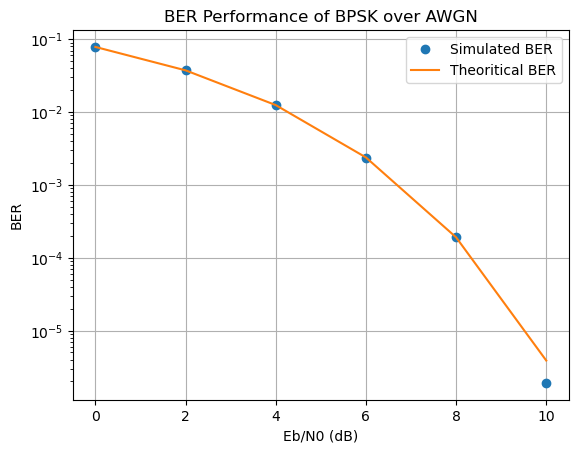

In [56]:
#Task 5 : Theoritical BER and comparison with simulated values

theoritical_BER = 0.5 * erfc(np.sqrt(EbN0_lin))

#semilog plot
plt.figure()
plt.semilogy(EbN0_dB,sim_BER,'o',label = 'Simulated BER')
plt.semilogy(EbN0_dB,theoritical_BER,'-',label = 'Theoritical BER')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.title("BER Performance of BPSK over AWGN")
plt.legend()
plt.grid()
plt.show()